In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Business-as-usual analysis

In [21]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from ema_workbench import load_results
from unbreakable.analysis.analyzer import *
from unbreakable.analysis.visualizer import *
sns.set_theme(style="ticks")

In [22]:
# Parameters for report writing
savefig = False
savetab = False

## Load results

In [29]:
# Load results
n_scenarios = 24
n_policies = 0
results = load_results(f'../experiments/scenarios={n_scenarios}, policies={n_policies}.tar.gz')

# Prepare outcomes
outcomes = prepare_outcomes(results, add_uncertainties=False, add_policies=False)

## EDA

### Single scenario, single district 

In [5]:
# Print all outcomes for a single scenario
scenario = 0
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)
numeric_columns = outcomes.columns[3:-1].tolist()
df[numeric_columns].round(2).style.format("{:,.2f}")

,random_seed,total_population,total_asset_loss,total_consumption_loss,tot_exposed_asset,median_productivity,tot_asset_surv,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,district_pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,mean_recovery_rate,n_new_poor_increase_pp
district,,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"94,661,181.00","8,666.91","1,244,727.08","1,102,204.76","47,442,177.05",0.63,"334,331,195.84",0.03,597.51,"1,591.22",914.27,"1,282,936.18","3,292.00",173.00,0.00,32.85,33.29,184.47,11.26,1.13,0.53,0.00
Castries,"94,661,181.00","70,959.09","32,313,122.99","22,258,832.49","1,587,405,663.34",0.11,"3,435,721,049.12",0.02,"3,724.36","6,213.45","2,976.86","31,062,668.40","15,948.00","1,033.00",0.00,34.78,34.94,597.66,10.37,1.45,0.15,0.00
Choiseul,"94,661,181.00","5,475.87","1,099,744.86","753,913.79","54,354,802.37",0.23,"377,890,219.98",0.02,195.01,"1,932.86",926.75,"1,111,847.84",923.00,33.00,0.00,26.55,27.09,386.60,15.60,1.46,0.15,0.00
Dennery,"94,661,181.00","11,590.78","2,734,846.91","1,642,116.54","125,372,604.01",2.46,"417,528,403.13",0.02,814.00,"3,383.57","1,934.66","2,667,414.34","5,216.00",394.00,0.00,23.52,24.00,201.73,6.91,1.67,2.16,0.00
Gros Islet,"94,661,181.00","27,467.06","10,534,858.22","8,568,517.14","532,061,766.39",0.70,"3,294,339,146.51",0.02,"1,978.25","2,841.95","1,040.60","10,932,607.53","3,245.00",67.00,74.00,15.39,15.12,433.14,16.39,1.23,0.69,0.27
Laborie,"94,661,181.00","6,828.32","2,135,457.30","1,396,234.03","99,235,698.32",0.12,"215,695,044.06",0.02,325.09,"5,123.26","2,964.26","2,035,118.22","1,599.00",9.00,8.00,23.26,23.36,429.49,7.05,1.53,0.16,0.12
Micoud,"94,661,181.00","17,435.51","4,860,458.69","3,733,585.07","231,995,156.10",0.26,"554,020,360.02",0.02,"1,338.09","6,056.25","2,698.00","4,766,541.74","5,433.00",671.00,0.00,38.18,38.78,279.02,7.81,1.30,0.25,0.00
Soufriere,"94,661,181.00","8,985.05","1,669,090.70","1,338,209.52","82,756,712.06",0.18,"535,928,432.44",0.02,401.24,"2,953.40",994.91,"1,679,254.31","2,295.00",0.00,5.00,31.47,31.49,333.52,13.17,1.25,0.26,0.06
Vieuxfort,"94,661,181.00","15,229.37","4,458,804.05","3,486,050.35","216,534,648.76",0.75,"1,266,550,258.12",0.02,"1,356.28","2,121.05","1,101.52","4,264,030.49","5,272.00",389.00,28.00,23.35,24.00,257.03,13.01,1.28,0.79,0.18


In [6]:
# Let's examine a single scenario in details
scenario = 200
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)

# And a single district as an example
district = 'Dennery'
print('District: ', district)
total_population = round(df.loc[district, 'total_population'])
n_affected = round(df.loc[district, 'n_affected_people'])
print('Total population: ', total_population)
print('Number of affected people: ', n_affected)

n_poor_initial = round(df.loc[district, 'n_poor_initial'])
n_new_poor = round(df.loc[district, 'n_new_poor'])
pct_poor_initial = round(n_poor_initial / total_population * 100, 2)
pct_new_poor = round((n_new_poor + n_poor_initial) / total_population * 100, 2)
pct_poor_increase = round(n_new_poor / total_population * 100, 2)
initial_poverty_gap = round(df.loc[district, 'initial_poverty_gap'], 2)
new_poverty_gap = round(df.loc[district, 'new_poverty_gap'], 2)
print()
print('Number of poor: ', n_poor_initial)
print('Number of new poor: ', n_new_poor)
print(f'Percentage of poor: {pct_poor_initial}%')
print(f'Percentage of new poor: {pct_new_poor}%')
print(f'Percentage of increase in poor: {pct_poor_increase}%')
print('Initial poverty gap: ', initial_poverty_gap)
print('New poverty gap: ', new_poverty_gap)

annual_average_consumption = round(df.loc[district, 'annual_average_consumption'])
annual_average_consumption_loss = round(df.loc[district, 'annual_average_consumption_loss'])
annual_average_consumption_loss_pct = round(df.loc[district, 'annual_average_consumption_loss_pct'])
print()

print('Annual average consumption: ', annual_average_consumption)
print('Annual average consumption loss: ', annual_average_consumption_loss)
print(f'Annual average consumption loss percentage: {annual_average_consumption_loss_pct}%')

print()
r = round(df.loc[district, 'r'], 2)
print('Socio-economic resilience: ', r)

District:  Dennery
Total population:  11591
Number of affected people:  495

Number of poor:  5216
Number of new poor:  0
Percentage of poor: 45.0%
Percentage of new poor: 45.0%
Percentage of increase in poor: 0.0%
Initial poverty gap:  23.52
New poverty gap:  23.73

Annual average consumption:  3384
Annual average consumption loss:  347
Annual average consumption loss percentage: 7%

Socio-economic resilience:  1.58


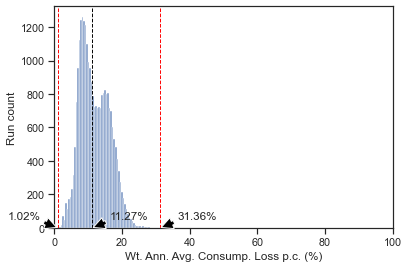

In [7]:
annotated_hist(outcomes, savefig)

### Multiple scenarios & multiple districts

In [8]:
# Let's aggregate across scenarios and take the mean
outcomes.iloc[:, 2:-1].groupby('district').mean(numeric_only=True).round(2).style.format("{:,.2f}")

,total_population,total_asset_loss,total_consumption_loss,tot_exposed_asset,median_productivity,tot_asset_surv,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,district_pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,mean_recovery_rate,n_new_poor_increase_pp
district,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"8,666.91","1,275,732.74","1,090,343.22","47,442,177.05",0.63,"334,331,195.84",0.03,639.68,"1,591.22",914.27,"1,282,936.18","3,292.00",231.82,41.95,32.85,33.19,177.71,10.43,1.19,0.56,0.48
Castries,"70,959.09","30,998,234.72","19,913,475.84","1,587,405,663.34",0.11,"3,435,721,049.12",0.02,"3,121.64","6,213.45","2,976.86","31,062,668.40","15,948.00",703.20,195.67,34.78,34.75,673.01,10.78,1.56,0.15,0.28
Choiseul,"5,475.87","1,110,507.60","731,892.56","54,354,802.37",0.23,"377,890,219.98",0.02,259.07,"1,932.86",926.75,"1,111,847.84",923.00,44.38,28.27,26.55,26.79,293.03,14.98,1.53,0.17,0.52
Dennery,"11,590.78","2,662,155.59","1,560,055.50","125,372,604.01",2.46,"417,528,403.13",0.02,574.31,"3,383.57","1,934.66","2,667,414.34","5,216.00",255.21,11.59,23.52,23.78,286.43,8.12,1.75,2.22,0.10
Gros Islet,"27,467.06","10,897,959.58","8,166,259.34","532,061,766.39",0.70,"3,294,339,146.51",0.02,"1,487.11","2,841.95","1,040.60","10,932,607.53","3,245.00",147.04,109.79,15.39,15.53,579.09,17.76,1.35,0.70,0.40
Laborie,"6,828.32","2,033,092.56","1,351,134.22","99,235,698.32",0.12,"215,695,044.06",0.02,310.35,"5,123.26","2,964.26","2,035,118.22","1,599.00",72.24,10.69,23.26,23.43,461.07,8.77,1.51,0.16,0.16
Micoud,"17,435.51","4,760,719.87","3,394,373.92","231,995,156.10",0.26,"554,020,360.02",0.02,817.20,"6,056.25","2,698.00","4,766,541.74","5,433.00",259.14,43.13,38.18,38.19,438.72,7.52,1.41,0.21,0.25
Soufriere,"8,985.05","1,675,773.22","1,259,217.81","82,756,712.06",0.18,"535,928,432.44",0.02,433.58,"2,953.40",994.91,"1,679,254.31","2,295.00",109.29,35.68,31.47,31.59,304.39,13.03,1.34,0.23,0.40
Vieuxfort,"15,229.37","4,230,835.29","3,284,119.57","216,534,648.76",0.75,"1,266,550,258.12",0.02,"1,018.35","2,121.05","1,101.52","4,264,030.49","5,272.00",316.05,131.96,23.35,23.82,339.04,15.84,1.34,0.71,0.87


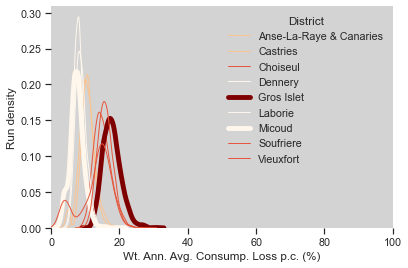

In [9]:
coloured_density_plots(outcomes, savefig, scheme='fisher_jenks', k=4)

In [10]:
tab = outcomes.iloc[:, 2:-1].groupby('district').describe().round(2)
column = 'n_new_poor'
tab = tab.sort_values(by=(column, 'mean'), ascending=False)
tab[[column]].iloc[:,1:].style.format("{:,.2f}")

## Number of new poor & Weeks in poverty

In [26]:
# Get the number of new poor in each district
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
d = {}
for district in districts:
    df = outcomes[outcomes['district'] == district]
    d[district] = df['n_new_poor'].values.tolist()

In [27]:
# Make a coloured table
tab = pd.DataFrame(d).describe().T.sort_values('mean', ascending=False).round(2).drop('count', axis=1)
tab.style.background_gradient(cmap='Blues', subset=['mean'])\
         .background_gradient(cmap='Reds', subset=['std'])\
         .background_gradient(cmap='Greens', subset=['min'])\
         .background_gradient(cmap='Greens', subset=['25%'])\
         .background_gradient(cmap='Greens', subset=['50%'])\
         .background_gradient(cmap='Greens', subset=['75%'])\
         .background_gradient(cmap='Greens', subset=['max'])\
         .format(decimal='.', thousands=',', precision=2)

,mean,std,min,25%,50%,75%,max
Castries,202.21,236.08,0.00,0.00,128.00,309.00,"1,741.00"
Vieuxfort,135.22,151.57,0.00,22.00,80.00,204.25,703.00
Gros Islet,109.29,121.86,0.00,0.00,75.00,174.00,853.00
Anse-La-Raye & Canaries,42.13,35.92,0.00,15.00,33.00,61.00,227.00
Micoud,40.68,62.21,0.00,0.00,14.00,55.00,457.00
Soufriere,35.94,36.57,0.00,5.00,27.00,56.00,237.00
Choiseul,28.18,23.75,0.00,11.00,23.00,42.00,156.00
Dennery,11.74,24.69,0.00,0.00,0.00,13.00,162.00
Laborie,11.01,16.72,0.00,0.00,0.00,19.00,126.00


In [24]:
average_years_in_poverty = get_weeks_in_poverty_tab(outcomes, max_years=10)
average_years_in_poverty.astype(int).style.background_gradient(cmap='Blues', axis=0)\
                                          .set_caption('Average Years in Poverty By District')

100%|██████████| 3000/3000 [00:38<00:00, 77.47it/s]


,0,1,2,3,4,5,6,7,8,9,>10
Anse-La-Raye & Canaries,0,0,7,19,8,5,1,0,0,0,0
Castries,0,7,14,23,31,28,34,19,11,12,19
Choiseul,0,0,0,2,3,3,4,3,3,2,4
Dennery,0,4,5,1,0,0,0,0,0,0,0
Gros Islet,0,0,24,32,27,12,4,2,1,2,0
Laborie,0,0,0,0,2,2,2,1,0,0,0
Micoud,0,0,0,12,15,6,3,0,0,0,0
Soufriere,0,0,0,4,9,4,3,3,4,2,3
Vieuxfort,0,1,36,50,43,1,0,0,0,0,0


In [25]:
average_years_in_poverty.sum(axis=1)

Anse-La-Raye & Canaries     42.123333
Castries                   202.196000
Choiseul                    28.119000
Dennery                     11.743667
Gros Islet                 109.298333
Laborie                     11.018667
Micoud                      40.683667
Soufriere                   35.952667
Vieuxfort                  135.200333
dtype: float64

## Average vulnerability

In [30]:
vulnerability_by_quintile = get_average_weighted_vulnerability(outcomes, quintile=True)
(vulnerability_by_quintile * 100).style.format("{:.0f}")

Quintile,1,2,3,4,5
District,,,,,
Anse-La-Raye & Canaries,57,52,44,50,48
Castries,45,49,48,49,44
Choiseul,44,48,48,45,45
Dennery,57,49,50,50,48
Gros Islet,32,45,47,47,48
Laborie,46,54,44,49,49
Micoud,53,38,49,42,45
Soufriere,40,43,43,48,44
Vieuxfort,51,49,51,44,46


In [31]:
vulnerability_by_decile = get_average_weighted_vulnerability(outcomes, quintile=False)
(vulnerability_by_decile * 100).style.format("{:.0f}")

Decile,1,2,3,4,5,6,7,8,9,10
District,,,,,,,,,,
Anse-La-Raye & Canaries,55,54,49,49,43,16,51,44,45,53
Castries,41,28,47,39,35,47,44,43,44,43
Choiseul,34,40,47,31,47,42,42,41,33,46
Dennery,43,56,41,35,52,41,44,44,45,37
Gros Islet,11,27,33,36,44,39,40,45,46,47
Laborie,32,43,52,42,26,42,33,48,44,41
Micoud,51,48,26,31,44,37,39,28,43,44
Soufriere,31,37,31,42,28,39,45,45,43,41
Vieuxfort,41,48,43,50,49,45,41,38,42,46


## Raincloud plots

Raincloud plot is a combination of a boxplot, a kernel density plot, and a dot plot. It is a great way to visualize the distribution of the data. Especially, when the distribution is skewed and you have a lot of data points.

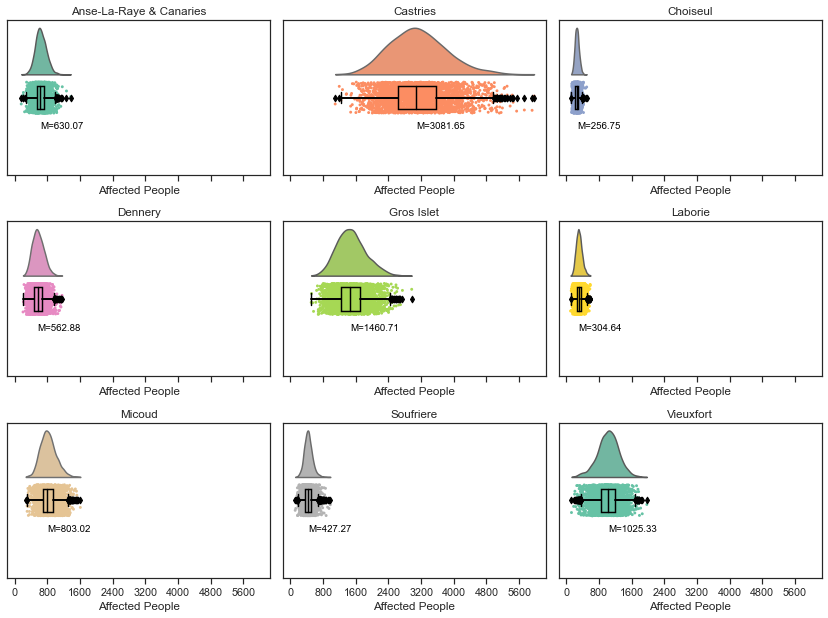

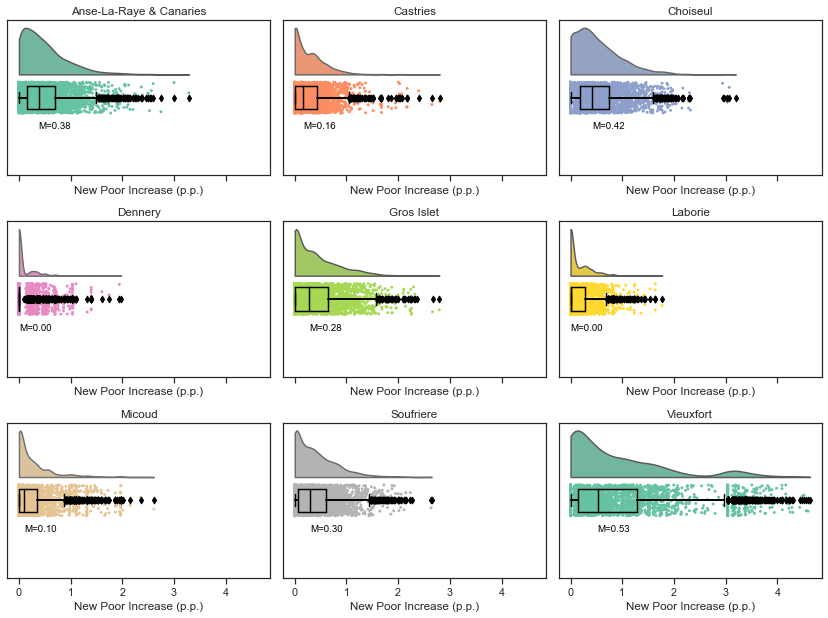

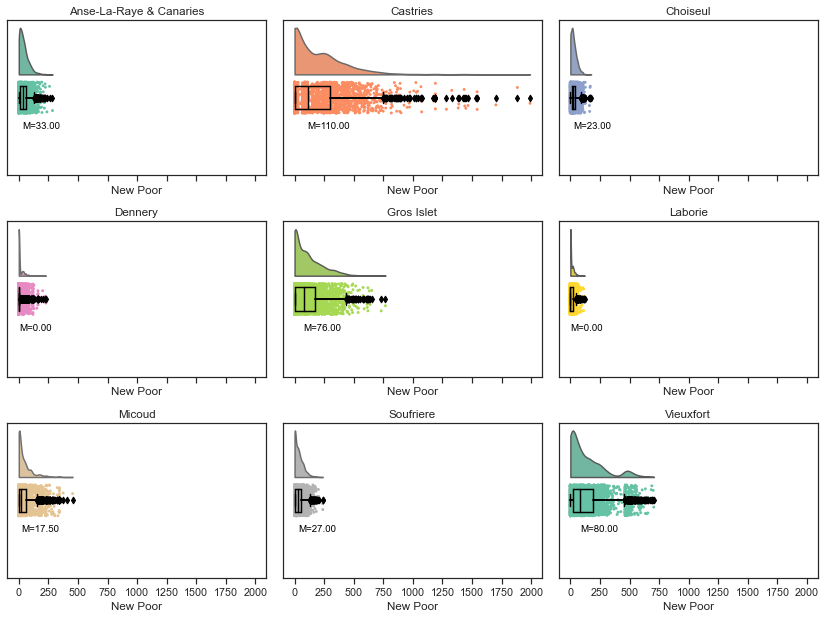

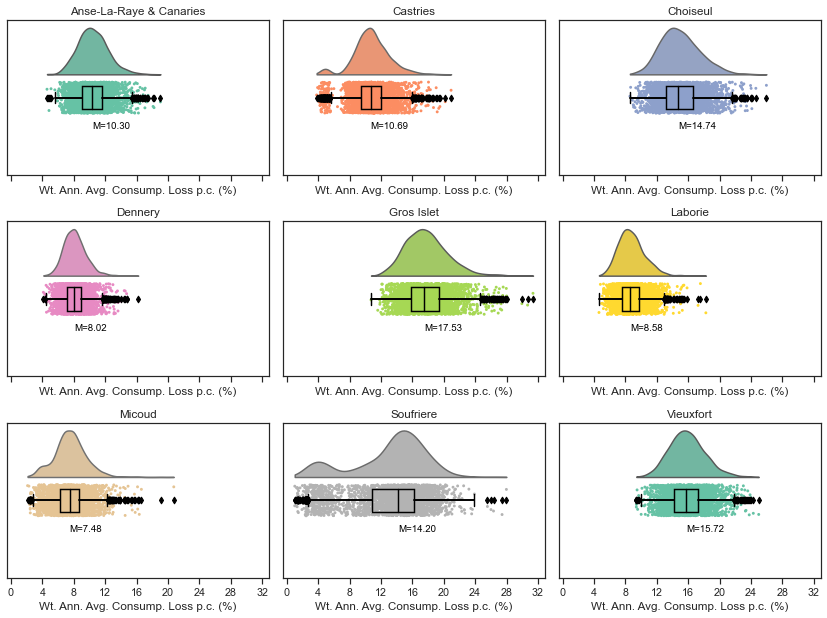

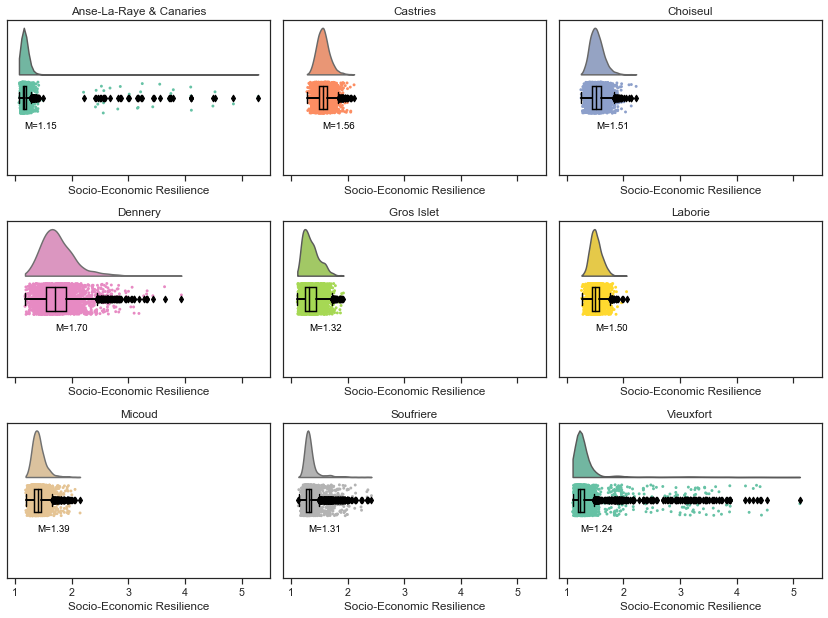

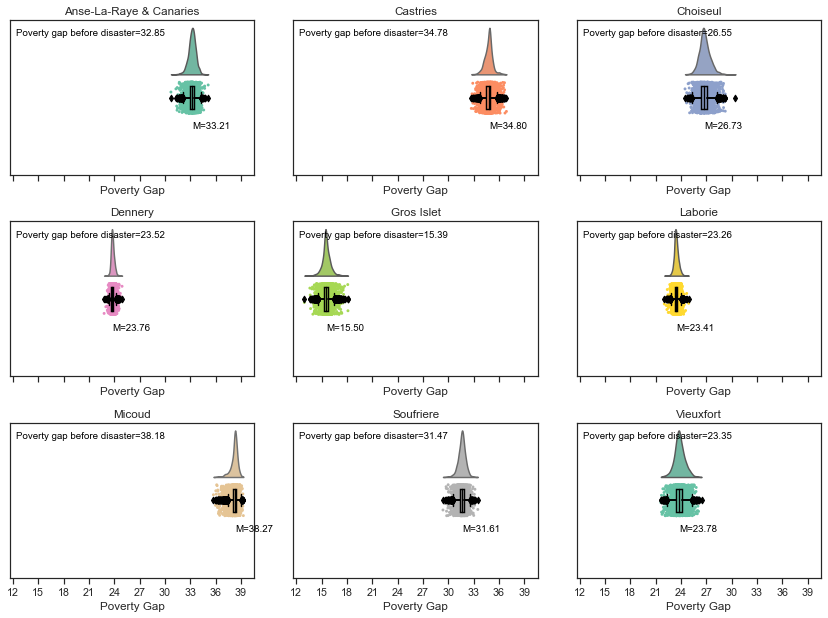

In [14]:
raincloud_plot(outcomes, savefig=savefig)

## Choropleth maps

Another way to visualize the outcomes is to use choropleth maps. These maps are useful when you have data that is aggregated by a geographic area. For example, if we have data on how many people became poor after a disaster in the districts of Saint Lucia, we could use a choropleth map to show these numbers.  

What is important to remember is that **these maps do not show the variance** within each district. Instead, they show the mean or median value for each district.

In [15]:
# Get the country shapefile and aggregated outcomes
country = gpd.read_file('../data/raw/shapefiles/Saint Lucia/gadm36_LCA_shp/gadm36_LCA_0.shp')
aggregation = 'median'
outcomes['district'].replace({'Anse-La-Raye \& Canaries' : 'Anse-La-Raye & Canaries'}, inplace=True)
aggregated_outcomes = get_spatial_outcomes(outcomes, aggregation=aggregation)

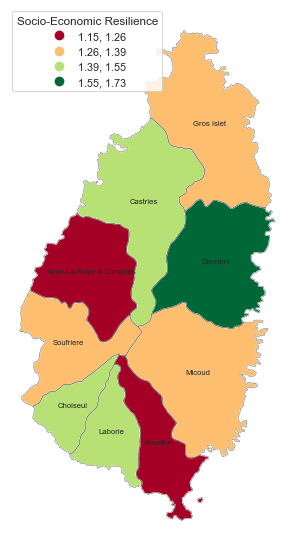

In [19]:
k = 4
scheme = 'fisher_jenks'
ax = aggregated_outcomes.plot(column='r', scheme=scheme, k=k, cmap='RdYlGn', legend=True, figsize=(10,10), legend_kwds={"title":"Socio-Economic Resilience", "loc" : "upper left"})
aggregated_outcomes.plot(ax=ax, color='none', edgecolor='black', linewidth=0.25)
ax.axis('off')
for idx, row in aggregated_outcomes.iterrows():
    ax.annotate(text=row['NAME_1'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
if savefig:
    plt.savefig(f'../reports/figures/analysis/soc_econ_res_map.png', dpi=300, bbox_inches='tight')

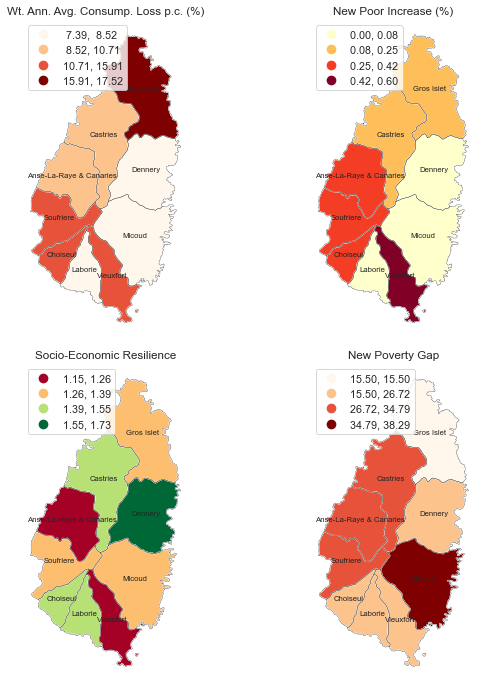

In [21]:
# Plot the outcomes in a 2 by 2 grid
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
outcomes_to_plot = ['annual_average_consumption_loss_pct', 'n_new_poor_increase_pp', 'r', 'new_poverty_gap']
titles = ['Wt. Ann. Avg. Consump. Loss p.c. (%)', 
          'New Poor Increase (%)', 
          'Socio-Economic Resilience', 'New Poverty Gap']
cmaps = ['OrRd', 'YlOrRd', 'RdYlGn', 'OrRd']
k = 4
for i, outcome in enumerate(outcomes_to_plot): 
    aggregated_outcomes.plot(column=outcome, scheme='fisher_jenks', cmap=cmaps[i], k=k, ax=ax[i//2, i%2], legend=True, legend_kwds={"loc" : "upper left"})
    aggregated_outcomes.plot(ax=ax[i//2, i%2], color='none', edgecolor='black', linewidth=0.25)
    ax[i//2, i%2].set_title(titles[i])
    ax[i//2, i%2].axis('off')
    for idx, row in aggregated_outcomes.iterrows():
        ax[i//2, i%2].annotate(text=row['NAME_1'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
# fig.suptitle(f'{aggregation.capitalize()} of 3,000 replications', fontsize=16)
fig.tight_layout()
if savefig:
    plt.savefig(f'../reports/figures/analysis/{aggregation}_outcomes_spatially.png', dpi=300, bbox_inches='tight')

A bivariate or bi-variate choropleth helps to visualise relations between two variables spatially. 

In [23]:
# Load asset damage data
asset_damage = pd.read_excel('../data/processed/asset_damage/Saint Lucia.xlsx')
asset_damage['district'].replace({'AnseLaRayeCanaries' : 'Anse-La-Raye & Canaries'}, inplace=True)
gdf = pd.merge(aggregated_outcomes, asset_damage, left_on='NAME_1', right_on='district', how='left')

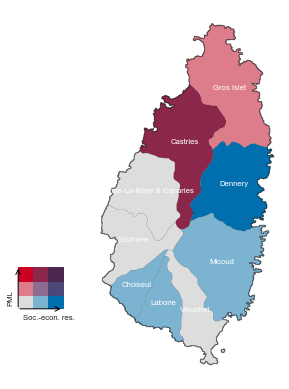

In [24]:
x_name = 'r'
y_name = 'pml'
x_label = 'Soc.-econ. res.'
y_label = 'PML'

tab = bivariate_choropleth(gdf.copy(), x_name, y_name, x_label, y_label, scheme='fisher_jenks', figsize=(7,6), return_table=True)
if savefig:
    plt.savefig('../reports/figures/analysis/bivariate_choropleth.png', dpi=300, bbox_inches='tight')

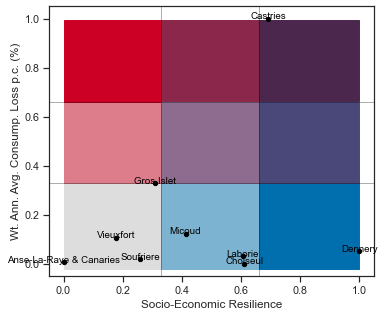

In [26]:
nine_quadrants_plot(gdf.copy(), x_name, y_name)
plt.xlabel('Socio-Economic Resilience')
plt.ylabel('Wt. Ann. Avg. Consump. Loss p.c. (%)')
if savefig:
    plt.savefig('../reports/figures/analysis/9_quadrants.png', dpi=300, bbox_inches='tight')